In [233]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

#### Загрузка данных

In [234]:
def load_data(csv_file):
    df = pd.read_csv(csv_file, sep="\t")
    df = df.iloc[:, 0:]
    df.dropna(inplace=True)
    return df

In [235]:
source_data = load_data("./Ushakov_dataset.tsv")

#### Изучение исходных данных

Вывод общей информации о столбцах данных и их типах

In [236]:
source_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21426 entries, 0 to 21425
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   payload  21426 non-null  object
 1   label    21426 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.9+ KB


Видим, что данные содержат 2 столбца с типами object (скорее всего - это строки) и int64

Смотрим пример данных из набора:

In [237]:
print(source_data["payload"][:10])
print(source_data["label"][:10])

0    SELECT * FROM leave WHERE church NOT BETWEEN '...
1                                    SELECT * FROM can
2                                                jared
3                                   barrenechea sadurn
4                                                   44
5      SELECT * FROM very WHERE found IN  ( 'wash',...
6    SELECT AVG ( truth )  FROM slope  SELECT SUM (...
7                  SELECT COUNT ( highestID ) FROM cry
8      SELECT breadID AS ID, ahead AS feed FROM unh...
9                                c/ rua mayor, 31, 1?e
Name: payload, dtype: object
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64


Проверка пропусков данных

In [238]:
source_data.isnull().sum()

payload    0
label      0
dtype: int64

Пропуски данных отсутствуют

Определение соотношения классов в исходном наборе данных:

In [239]:
source_data["label"].value_counts(normalize=True) * 100

label
0    62.946887
1    37.053113
Name: proportion, dtype: float64

Видно, что классы не сбалансированы, хотя дисбаланс не очень большой

Сбалансируем данные с помощью random oversampling (хотя здесь гораздо больше бы подошла генерация новых данных, например, с помощью GAN, но это достаточно не тривиальная задача):

In [240]:
normal_count = source_data["label"].value_counts()[0]
sql_injection_count = source_data["label"].value_counts()[1]
sql_injection_data = source_data.loc[source_data["label"] == 1]
disbalance_count = normal_count - sql_injection_count
for _ in range(disbalance_count):
    source_data = pd.concat([source_data, sql_injection_data.sample(n=1, random_state=None)], ignore_index=True)
source_data["label"].value_counts(normalize=True) * 100

label
0    50.0
1    50.0
Name: proportion, dtype: float64

#### Подготовка данных

Основная цель предварительной обработки данных — подготовить текстовые данные для дальнейшего анализа. Это включает следующие шаги:

- Токенизация: Разбиение текста на отдельные слова или фразы (токены).
- Очистка текста: Удаление лишних символов, знаков препинания, стоп-слов и приведение слов к нижнему регистру.
- Лемматизация или стемминг: Приведение слов к их начальной или базовой форме для уменьшения количества уникальных слов.


**RegexpTokenizer** (регулярный токенизатор) — это инструмент для разбиения текста на токены (слова или фразы) с использованием регулярных выражений. Регулярные выражения позволяют задавать сложные шаблоны для поиска и извлечения нужных частей текста.

В качестве простой подготовки (нормализации) данных будем использовать:
* Приведение всех строк к нижнему регистру (lowercase)
* Уберем все пробельные символы с начала строки и с ее конца

In [241]:
def normalize_payload(source: str):
    return source.lower().strip()

source_data["payload"] = source_data["payload"].map(normalize_payload)

print(source_data["payload"][:10])
print(source_data["label"][:10])

0    select * from leave where church not between '...
1                                    select * from can
2                                                jared
3                                   barrenechea sadurn
4                                                   44
5    select * from very where found in  ( 'wash', '...
6    select avg ( truth )  from slope  select sum (...
7                  select count ( highestid ) from cry
8     select breadid as id, ahead as feed from unhappy
9                                c/ rua mayor, 31, 1?e
Name: payload, dtype: object
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64


Разделим dataframe на тестовые данные и тренировочные данные

In [242]:
source_data = pd.read_csv("./Ushakov_dataset.tsv", sep="\t", engine="python")
train_data, test_data = train_test_split(source_data, test_size=0.5)
x_train, y_train = train_data["payload"].values, train_data["label"].values
x_test, y_test = test_data["payload"].values, test_data["label"].values

#### Глобально отключаю предупреждения (warnings)

In [243]:
import warnings
warnings.filterwarnings("ignore")

#### Векторизация текста

Проведем векторизацию данных с помощью CountVectorizer и TfidfVectorizer.

`CountVectorizer` — это инструмент для преобразования текста в числовые векторы путем подсчета количества вхождений каждого слова в документ. В результате каждый документ представляется как вектор, где каждая позиция соответствует определенному слову, а значение в позиции — количество вхождений этого слова в документе.

`TfidfVectorizer` (Term Frequency-Inverse Document Frequency Vectorizer) — это инструмент обработки текста, используемый для преобразования текстовых данных в числовые векторы на основе значимости слов. Этот метод учитывает как частоту появления слова в документе (term frequency, TF), так и обратную частоту появления слова во всех документах коллекции (inverse document frequency, IDF).

Для векторизации используем подготовленный класс `FeatureExtractor`

`FeatureExtractor` — поддерживает следующие режимы работы:

* TF-IDF ('tf-idf'):

    Описание: TF-IDF (Term Frequency-Inverse Document Frequency) — это метод вычисления веса слова в документе относительно его важности в коллекции документов.
    Применение: Каждый документ представляется в виде вектора, где каждая компонента отражает вес термина (слова), вычисленный по формуле TF-IDF. Этот метод учитывает и частоту встречаемости слова в документе (TF) и обратную частоту документа (IDF).
    Пример: Используется для извлечения ключевых признаков из текста, что полезно для задач, таких как классификация текстов, кластеризация и информационный поиск.

* TF-IDF с N-граммами ('tf-idf_ngram'):

    Описание: Этот режим также использует TF-IDF, но включает векторизацию не только отдельных слов, но и последовательностей из N смежных слов (N-грамм).
    Применение: Учитывает контекстуальные зависимости между последовательными словами, что может улучшить качество представления текста, особенно для задач, где важен порядок слов, например, в задачах машинного перевода или анализе sql запросов.

* Мешок слов ('bag_of_words'):

    Описание: Это простой метод векторизации, который представляет каждый документ в виде вектора, где каждая компонента соответствует наличию или отсутствию конкретного слова из словаря.
    Применение: Подходит для задач, где важно только наличие слова в тексте, а не его частота или важность. Обычно используется в моделях, требующих быстрое обучение и простоту интерпретации, таких как методы наивного Байеса или простые линейные модели.

* Мешок символов ('bag_of_characters'):

    Описание: Этот метод представляет текст в виде вектора, где каждая компонента соответствует наличию или отсутствию конкретного символа в тексте.
    Применение: Полезен в задачах, где важны структура или последовательность символов, таких как распознавание рукописного текста или анализ кодов программ.

In [244]:
class ExtractMethods:
    TF_IDF = "tf-idf"
    TF_IDF_NGRAM = "tf-idf_ngram"
    BAG_OF_WORDS = "bag_of_words"
    BAG_OF_CHAR = "bag_of_characters"

class FeatureExtractor:
  def __init__(self, method, *args, **kwargs):
    self.args = args
    self.kwargs = kwargs
    self.notes = {}
    self.vectorizer = self._get_vectorizer(method, args, kwargs)

  def _get_vectorizer(self, method, *args, **kwargs):
    token = RegexpTokenizer(r"[a-zA-Z0-9]+")
    match method:
      case ExtractMethods.TF_IDF:
          return TfidfVectorizer(tokenizer = token.tokenize, *self.args, **self.kwargs)
      case ExtractMethods.TF_IDF_NGRAM:
          return TfidfVectorizer(
            lowercase=True, stop_words="english", 
            ngram_range = (1, 3),
            tokenizer = token.tokenize, analyzer="char"
          )
      case ExtractMethods.BAG_OF_WORDS:
          return CountVectorizer(analyzer="word",  **self.kwargs)
      case ExtractMethods.BAG_OF_CHAR:
          return CountVectorizer(analyzer="char", tokenizer = token.tokenize, **self.kwargs)
      case _:
          raise ValueError(f"Unknown feature extraction method: {self.method}")


  def fit_extract(self, x_train):
      return self.vectorizer.fit_transform(x_train)

  def extract_features(self, x):
      return self.vectorizer.transform(x)

Проведем векторизацию всеми заданными (выше) методами:

In [245]:
tf_idf_extractor = FeatureExtractor(ExtractMethods.TF_IDF)
tf_idf_ngram_extractor = FeatureExtractor(ExtractMethods.TF_IDF_NGRAM)
bag_of_words_extractor = FeatureExtractor(ExtractMethods.BAG_OF_WORDS)
bag_of_chars_extractor = FeatureExtractor(ExtractMethods.BAG_OF_CHAR)

In [246]:
tf_idf_feature = tf_idf_extractor.fit_extract(x_train)
tf_idf_ngram_feature = tf_idf_ngram_extractor.fit_extract(x_train)
bag_of_words_feature = bag_of_words_extractor.fit_extract(x_train)
bag_of_chars_feature = bag_of_chars_extractor.fit_extract(x_train)

#### Сравнение методов векторизации

Для сравнения методов векторизации обучим простую модель LogisticRegression на этих векторах и проведем оценку следующих показателей точности:
* Accuracy
* Precision
* Recall
* F1-score

In [247]:
from sklearn.linear_model import LogisticRegression

def check_vectorization(vectorizier_name, vectorizier):
    model = LogisticRegression(max_iter=5000)
    x_train_result = vectorizier.fit_transform(x_train)
    x_test_result = vectorizier.transform(x_test)
    model.fit(x_train_result, y_train)
    y_pred = model.predict(x_test_result)
    metrics = {
        "Vectorizer": vectorizier_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted')
    }

    return metrics

In [248]:
results = []

extractors = {
    "TF-IDF": tf_idf_extractor.vectorizer,
    "TF-IDF N-Gram": tf_idf_ngram_extractor.vectorizer,
    "Bag of Words": bag_of_words_extractor.vectorizer,
    "Bag of Characters": bag_of_chars_extractor.vectorizer
}

for name, vectorizer in extractors.items():
    metrics = check_vectorization(name, vectorizer)
    results.append(metrics)

df_results = pd.DataFrame(results)
print(df_results)

          Vectorizer  Accuracy  Precision    Recall  F1-score
0             TF-IDF  0.986278   0.986447  0.986278  0.986236
1      TF-IDF N-Gram  0.995146   0.995171  0.995146  0.995141
2       Bag of Words  0.990199   0.990195  0.990199  0.990196
3  Bag of Characters  0.990666   0.990693  0.990666  0.990652


Выводим результаты сравнения эффективности методов векторизации на диаграмму

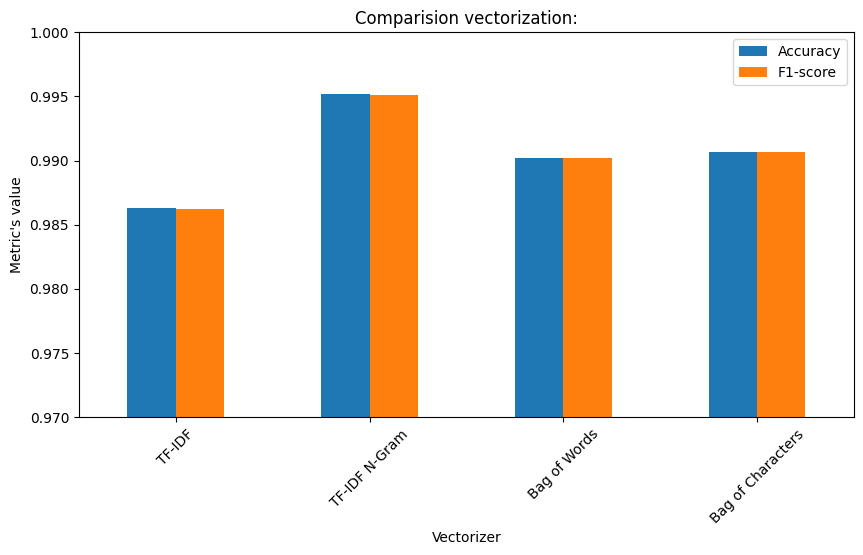

In [249]:
import matplotlib.pyplot as plt

df_results.set_index("Vectorizer")[["Accuracy", "F1-score"]].plot(kind="bar", figsize=(10,5))
plt.title("Comparision vectorization:")
plt.ylabel("Metric's value")
plt.ylim(0.97, 1.0)
plt.xticks(rotation=45)
plt.show()


#### Вывод

* Наилучшие показатели были достигнуты при использовании метода TF-IDF N-Gram. Это указывает на то, что учёт последовательностей символов (n-грамм) позволяет более полно уловить контекст и характерные шаблоны для распознавания SQL-инъекций
* Метод Bag of Characters занял второе место (Accuracy = 0.989545), показывая, что посимвольное представление может захватывать особенности синтаксиса SQL-инъекций (например, необычные комбинации символов `' -- ; =` и т.д.)
* Методы TF-IDF и Bag of Words показали схожие результаты (Accuracy = 0.988145 у Bag of Words, Accuracy = 0.986558 у TF-IDF), что свидетельствует о том, что базовое представление текста через частоты слов также достаточно эффективно, но уступает n-граммному подходу (который способен улавливать контекст).

Поэтому в дальнейшем мы будем использовать в качестве метода векторизации - TF-IDF N-Gram

#### Отбор токенов (Отбор признаков)

Отбор токенов (или признаков) является важным шагом, который позволяет уменьшить размерность данных, улучшить производительность модели и избежать переобучения. Для этого используются различные методы, включая статистические и алгоритмические подходы:

- `SelectFromModel`: Метод для отбора признаков, основанный на важности признаков, которую определяет обученная модель. Например, можно использовать Lasso (линейная модель с L1-регуляризацией) для оценки важности признаков.

- `TruncatedSVD`: Метод понижения размерности, который применим к разреженным матрицам, например, к тем, которые получены с помощью `CountVectorizer` или `TfidfVectorizer`. `TruncatedSVD` уменьшает размерность данных, сохраняя наиболее важную информацию.

Для выбора признаков используем `FeatureSelecter` — класс, реализующий отбор ключевых токенов из общего набора. Отбор производится двумя комбинацией двух методов: `SelectFromModel`(`Lasso`) и `TruncatedSVD`.

In [250]:
class FeatureSelecter:
    def __init__(self, n_components):
        self._scaler = StandardScaler(with_mean=False)
        self._lasso_selecter = SelectFromModel(Lasso(alpha=0.001, random_state=10))
        self._pca = TruncatedSVD(n_components=n_components)

    def fit_transform(self, x_train, y_train):
        self._scaler.fit(x_train)
        self._lasso_selecter.fit(self._scaler.transform(x_train), y_train)
        self._pca.fit(self._lasso_selecter.transform(self._scaler.transform(x_train)))
        
        return self._pca.transform(self._lasso_selecter.transform(self._scaler.transform(x_train)))

    def transform(self, x):
        return self._pca.transform(self._lasso_selecter.transform(self._scaler.transform(x)))

Выберем 100 самых важных признаков
PS. Количество отбираемых признаков является гиперпараметром модели, меняя который, можно изменять получаемые результаты

In [251]:
feature_selecter = FeatureSelecter(100)
x_selected_features = feature_selecter.fit_transform(tf_idf_ngram_feature, y_train)

#### Оценка и выбор лучшей модели

Мы будем выбирать лучшую модель из следующих:
* XGBoost
* SVC
* NuSVC
* KNeighbors
* DecisionTree
* RandomForest
* AdaBoost
* Bagging
* ExtraTrees
* LinearSVC

In [252]:
class Models:
    XGBOOST = "XGBoost"
    SVC = "SVC"
    NU_SVC = "NuSVC"
    KNEIGHBORS = "KNeighbors"
    DECISION_TREE = "DecisionTree"
    RANDOM_FOREST = "RandomForest"
    ADABOOST = "AdaBoost"
    BAGGING = "Bagging"
    EXTRA_TREES = "ExtraTrees"
    LINEAR_SVC = "LinearSVC"


class ModelFabric:
    @staticmethod
    def create_model(model_name, *args, **kwargs):
        match model_name:
            case Models.XGBOOST:
                return xgb.XGBClassifier(*args, **kwargs)
            case Models.SVC:
                return SVC(gamma=2, C=1, *args, **kwargs)
            case Models.NU_SVC:
                return NuSVC(*args, **kwargs)
            case Models.KNEIGHBORS:
                return KNeighborsClassifier(3, *args, **kwargs)
            case Models.DECISION_TREE:
                return DecisionTreeClassifier(max_depth=5, *args, **kwargs)
            case Models.RANDOM_FOREST:
                return RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, *args, **kwargs)
            case Models.ADABOOST:
                return AdaBoostClassifier( *args, **kwargs)
            case Models.BAGGING:
                return BaggingClassifier(*args, **kwargs)
            case Models.EXTRA_TREES:
                return ExtraTreesClassifier(*args, **kwargs)
            case Models.LINEAR_SVC:
                return LinearSVC(*args, **kwargs)
            case _:
                raise ValueError(f"Unsupported model name: {model_name}")

Для выбора лучшей модели мы будем использовать кросс-валидацию

In [253]:
def cross_validation(clf, x_data, y_data):
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=666)
    accuracy_scores = []
    clfs = []

    for train_idx, test_idx in skfold.split(x_data, y_data):
        x_train, x_test = x_data[train_idx], x_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        clfs.append(clf)

    best_clf = clfs[max(enumerate(accuracy_scores), key=lambda x: x[1])[0]]

    return accuracy_scores, best_clf

Для каждой модели из тех, которые мы рассматриваем, с помощью кроссвалидации получаем результаты и сохраняем их

In [254]:
model_types = [Models.XGBOOST,
               Models.SVC,
               Models.NU_SVC,
               Models.KNEIGHBORS,
               Models.DECISION_TREE,
               Models.RANDOM_FOREST,
               Models.ADABOOST,
               Models.BAGGING,
               Models.EXTRA_TREES,
               Models.LINEAR_SVC]

scores_data = {}
models_data = {}

for model_type in model_types:
    model = ModelFabric.create_model(model_type)
    score, best_model = cross_validation(model, x_selected_features, y_train)
    scores_data[model_type] = score
    models_data[model_type] = best_model

Выведем результаты сравнения моделей в виде графиков

XGBoost
Точности на фолдах: [0.9943993279193504, 0.9960795295435452, 0.9943993279193504]
Средняя точность: 0.9949593951274153


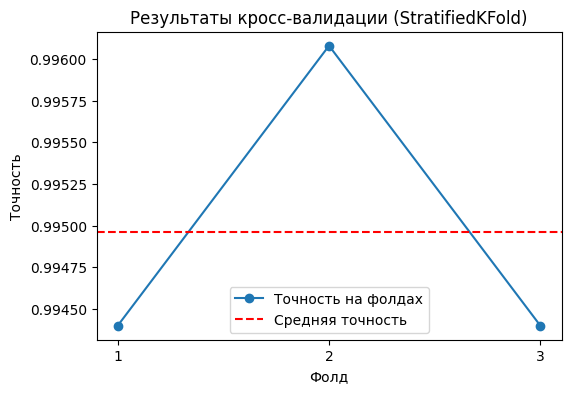

SVC
Точности на фолдах: [0.6530383646037524, 0.6477177261271353, 0.6538784654158499]
Средняя точность: 0.6515448520489125


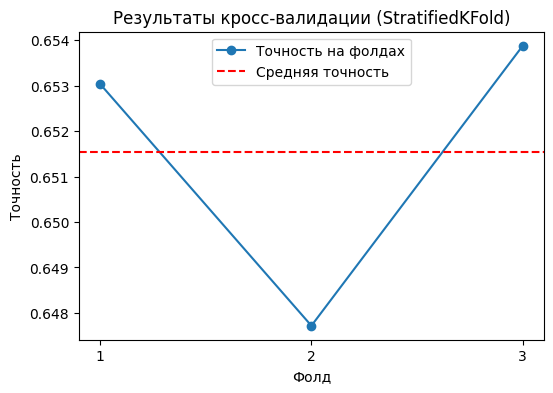

NuSVC
Точности на фолдах: [0.9563147577709326, 0.956594791374965, 0.9523942873144777]
Средняя точность: 0.9551012788201251


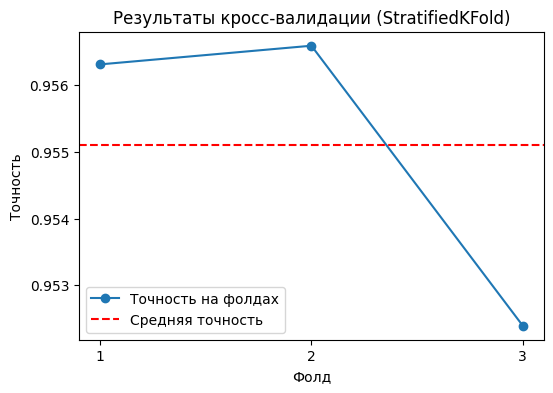

KNeighbors
Точности на фолдах: [0.9941192943153179, 0.9932791935032204, 0.9921590590870905]
Средняя точность: 0.9931858489685429


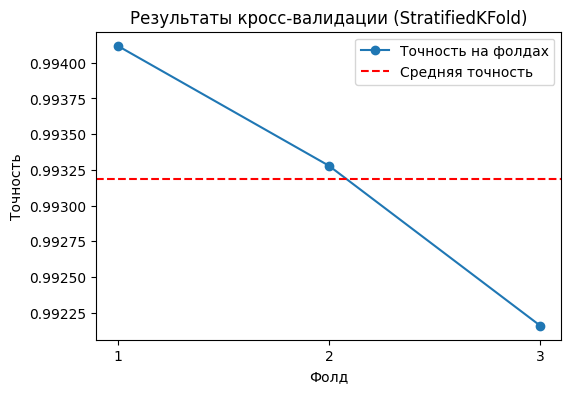

DecisionTree
Точности на фолдах: [0.9871184542145057, 0.9899187902548305, 0.990758891066928]
Средняя точность: 0.9892653785120881


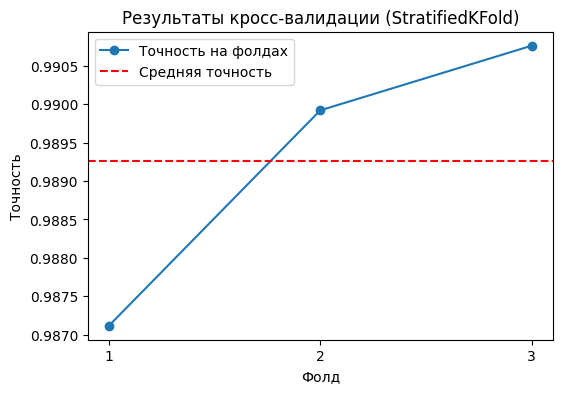

RandomForest
Точности на фолдах: [0.9109493139176701, 0.9179501540184822, 0.9022682721926631]
Средняя точность: 0.9103892467096051


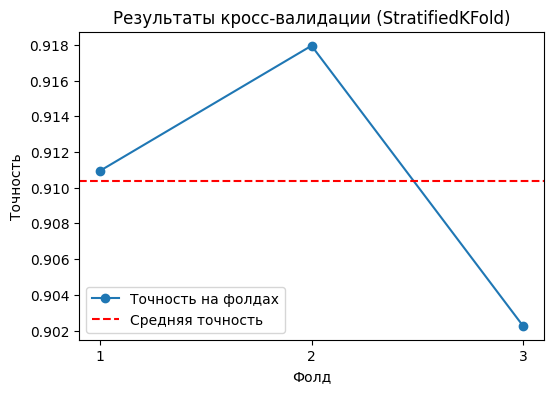

AdaBoost
Точности на фолдах: [0.991318958274993, 0.991318958274993, 0.9910389246709606]
Средняя точность: 0.9912256137403155


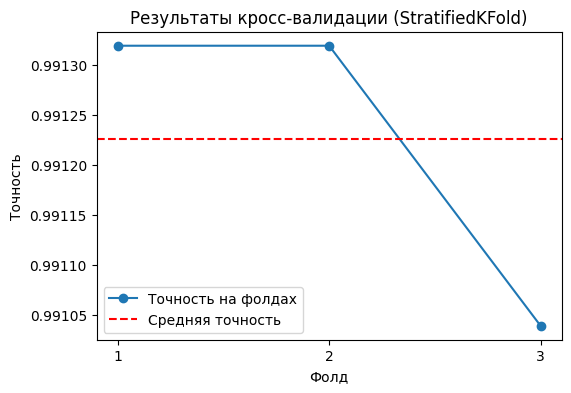

Bagging
Точности на фолдах: [0.990198823858863, 0.992439092691123, 0.991318958274993]
Средняя точность: 0.991318958274993


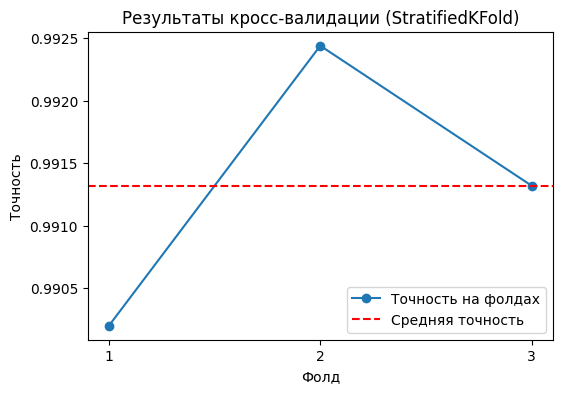

ExtraTrees
Точности на фолдах: [0.9946793615233828, 0.9966395967516102, 0.9943993279193504]
Средняя точность: 0.9952394287314478


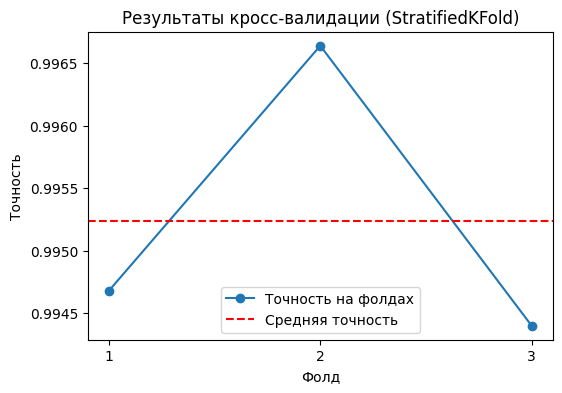

LinearSVC
Точности на фолдах: [0.992439092691123, 0.9946793615233828, 0.9904788574628955]
Средняя точность: 0.9925324372258005


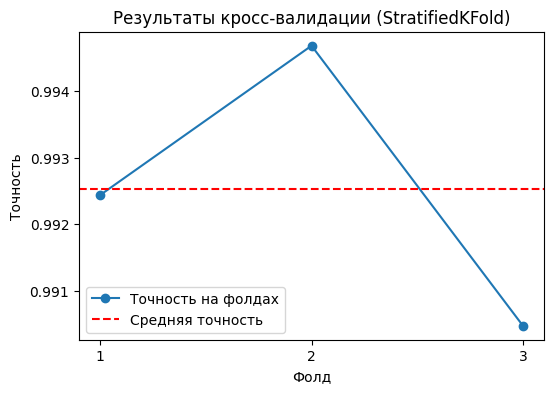

In [255]:
avg_accuracies = []
for model_type in model_types:
    score = scores_data[model_type]
    avg_accuracy = sum(score)/len(score)
    avg_accuracies.append((model_type, avg_accuracy))
    print(model_type)
    print("Точности на фолдах:", score)
    print("Средняя точность:", avg_accuracy)

    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(score)+1), score, marker="o", linestyle="-", label="Точность на фолдах")
    plt.axhline(y=sum(score)/len(score), color="r", linestyle="--", label="Средняя точность")

    plt.xticks(range(1, len(score)+1))
    plt.xlabel("Фолд")
    plt.ylabel("Точность")
    plt.title("Результаты кросс-валидации (StratifiedKFold)")
    plt.legend()
    plt.show()

Отсортируем модели по средней точности в порядке убавания:

In [256]:
for model, avg_accuracy in sorted(avg_accuracies, key=lambda item: item[1], reverse=True):
    print(f"{model} : {avg_accuracy}")

ExtraTrees : 0.9952394287314478
XGBoost : 0.9949593951274153
KNeighbors : 0.9931858489685429
LinearSVC : 0.9925324372258005
Bagging : 0.991318958274993
AdaBoost : 0.9912256137403155
DecisionTree : 0.9892653785120881
NuSVC : 0.9551012788201251
RandomForest : 0.9103892467096051
SVC : 0.6515448520489125


#### Выводы:

* Лидер (самая лучшая модель) - XGBoost; средняя точность у нее 0.9955194623354803
* Второе место - ExtraTrees; средняя точность у нее 0.9954261178008027
* Хорошие результаты (со средней точностью не ниже 0.99) показывают следующие модели: AdaBoost, KNeighbors, Bagging, LinearSVC, DecisionTree
* Достаточно средние результаты показывают следующие модели: NuSVC (со средней точностью 0.9561280687015775) и RandomForest (со средней точностью 0.9311117334080089)
* Модель SVC показала достаточно плохие результаты - средняя точность у нее 0.6490245496126202

Следует сказать, что на данный момент мы никак не занимались настройкой гиперпараметров.

Ну и очевидный выбор для решения нашей задачи - XGBoost

#### Проверка на тренировочных данных

Построим confusion matrix для интерпретации результатов предсказания моделей.

In [257]:
def plot_confusion_matrix(y_expect, y_pred, title):
    cm = confusion_matrix(y_expect, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Normal','SQL-Injection'], yticklabels=['Normal','SQL-Injection'])
    plt.xlabel('Prediction',fontsize=13)
    plt.ylabel('Actual',fontsize=13)
    plt.title(title,fontsize=17)
    plt.show()

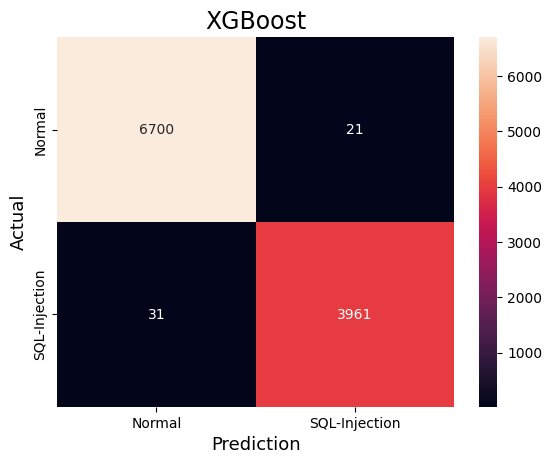

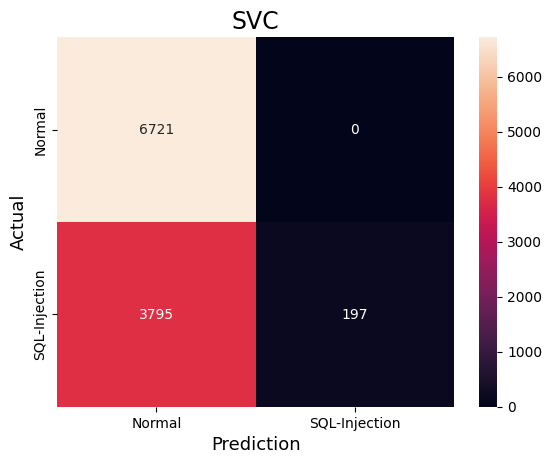

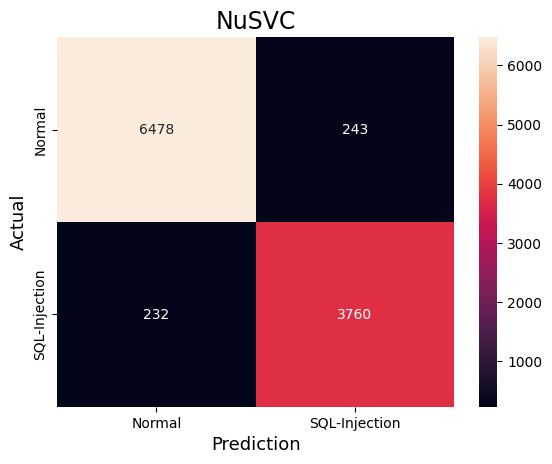

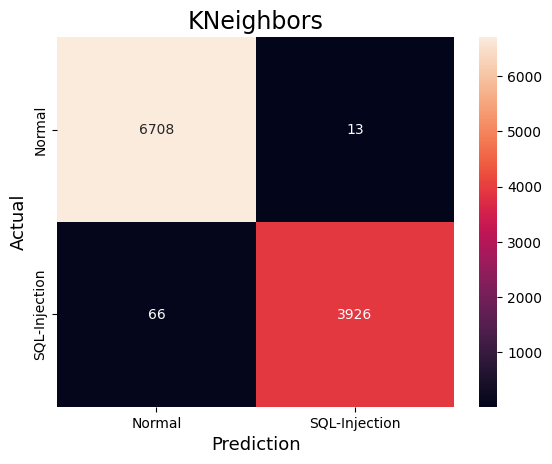

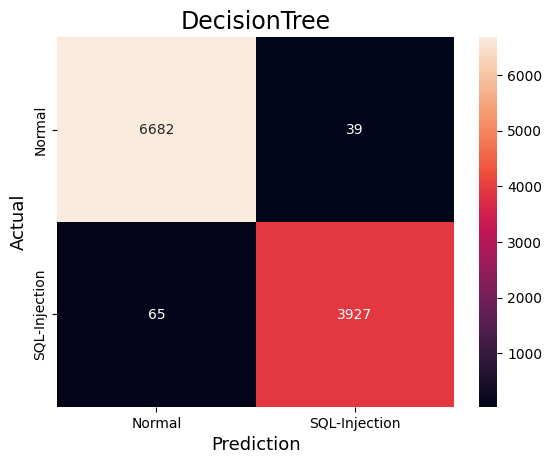

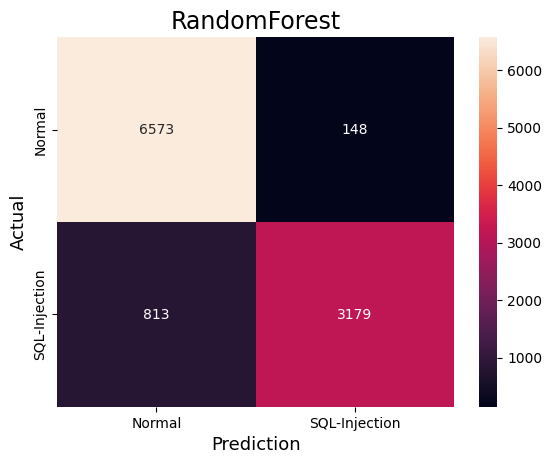

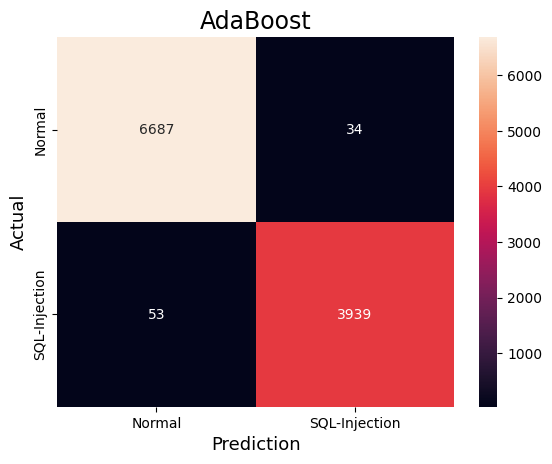

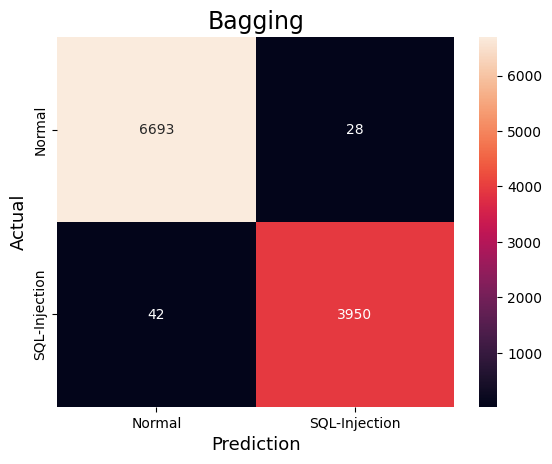

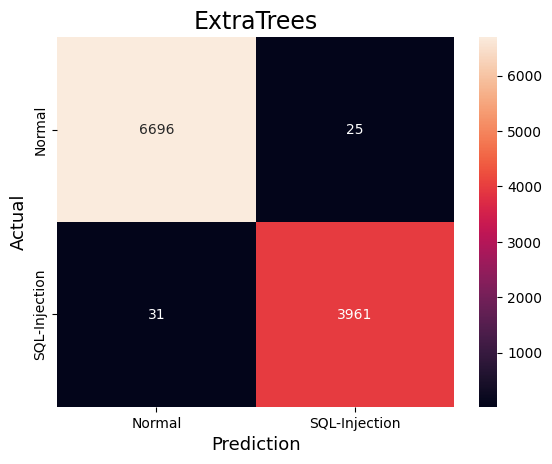

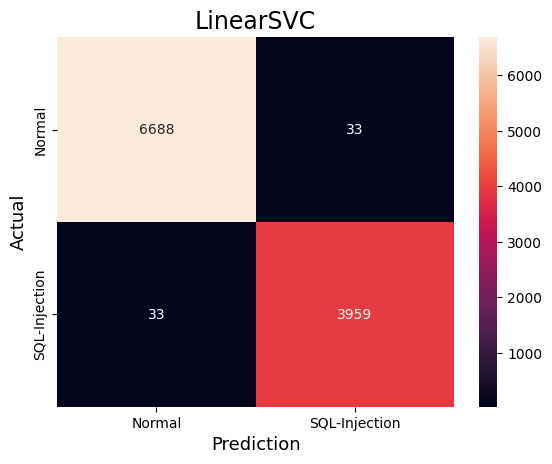

In [258]:
x_test_extracted = tf_idf_ngram_extractor.extract_features(x_test)
x_test_selected = feature_selecter.transform(x_test_extracted)

pred_dict = {}

for model_type in model_types:
    current_model = models_data[model_type]
    y_pred = current_model.predict(x_test_selected)
    pred_dict[model_type] = y_pred
    plot_confusion_matrix(y_test, y_pred, model_type)

Выведем confusion matrix для наглядности:

In [259]:
def prepare_metrics(y_pred, model_name):
    metrics = {
        "model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted')
    }
    return metrics

results = []

for model_type in model_types:
    current_model = models_data[model_type]
    metrics = prepare_metrics(pred_dict[model_type], model_type)
    results.append(metrics)

df_results = pd.DataFrame(results)
print(df_results)

          model  Accuracy  Precision    Recall  F1-score
0       XGBoost  0.995146   0.995145  0.995146  0.995145
1           SVC  0.645757   0.773596  0.645757  0.524292
2         NuSVC  0.955661   0.955688  0.955661  0.955674
3    KNeighbors  0.992626   0.992658  0.992626  0.992616
4  DecisionTree  0.990292   0.990292  0.990292  0.990286
5  RandomForest  0.910296   0.914367  0.910296  0.908335
6      AdaBoost  0.991879   0.991878  0.991879  0.991875
7       Bagging  0.993466   0.993465  0.993466  0.993464
8    ExtraTrees  0.994773   0.994772  0.994773  0.994772
9     LinearSVC  0.993839   0.993839  0.993839  0.993839


Анализ confusion matrix также показывает, что модель XGBoost лучшая модель для нашей задачи

#### Переобучение лучшей модели на всем наборе данных

In [260]:
x_total, y_total = source_data["payload"].values, source_data["label"].values
x_total_extracted = tf_idf_ngram_extractor.fit_extract(x_total)
x_selected_total = feature_selecter.fit_transform(x_total_extracted, y_total)
model_total = ModelFabric.create_model(Models.XGBOOST)
_ = model_total.fit(x_selected_total, y_total)

#### Предсказание для submission

In [261]:
data_for_prediction = load_data("./validate.tsv")
x_for_prediction = data_for_prediction["payload"]
x_for_prediction_extracted = tf_idf_ngram_extractor.extract_features(x_for_prediction)
x_for_prediction_selected = feature_selecter.transform(x_for_prediction_extracted)
y_predicted = model_total.predict(x_for_prediction_selected)

In [262]:
result = pd.DataFrame({"ID": range(len(y_predicted)), "TARGET": y_predicted})
result.to_csv("./submission_Ushakov.csv", index=False)

Мои результат на kaggle:

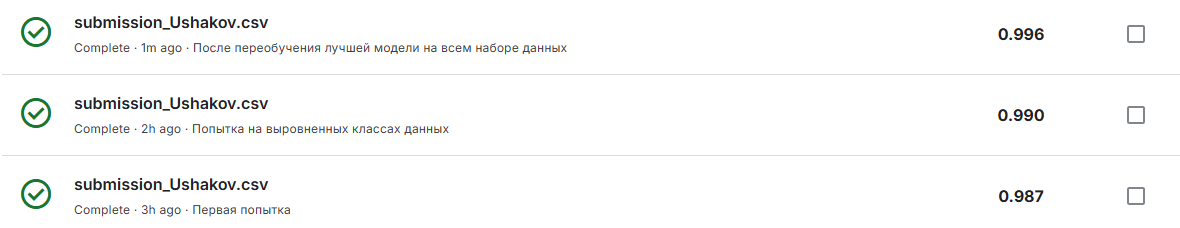

Получены следующие результаты:
1. Первый результат получен в результате нормализации исходных данных, выбора модели векторизации TF-IDF N-Gram и модели XGBoost; его значение 0.987
2. Второй результат получен после дополнительного выравнивания классов с помощью random oversampling; его результат 0.990
3. Третий результат получен после переобучения лучшей модели на всем объеме исходных данных; его значение 0.996

#### Сохраняю dump модели

In [263]:
import pickle
with open(r"./Ushakov_model.pkl", "wb") as f:
    pickle.dump(model_total, f)

#### Экспериментальный раздел

Проверим как другие способы векторизации влияют на результаты (при использовании тех же моделей)

In [264]:
# extractors
tf_idf_extractor = FeatureExtractor(ExtractMethods.TF_IDF)
tf_idf_ngram_extractor = FeatureExtractor(ExtractMethods.TF_IDF_NGRAM)
bag_of_words_extractor = FeatureExtractor(ExtractMethods.BAG_OF_WORDS)
bag_of_chars_extractor = FeatureExtractor(ExtractMethods.BAG_OF_CHAR)
# features
tf_idf_feature = tf_idf_extractor.fit_extract(x_train)
tf_idf_ngram_feature = tf_idf_ngram_extractor.fit_extract(x_train)
bag_of_words_feature = bag_of_words_extractor.fit_extract(x_train)
bag_of_chars_feature = bag_of_chars_extractor.fit_extract(x_train)
# selected features
feature_selecter = FeatureSelecter(60)
tf_idf_feature_selected = feature_selecter.fit_transform(tf_idf_feature, y_train)
tf_idf_ngram_feature_selected = feature_selecter.fit_transform(tf_idf_ngram_feature, y_train)
bag_of_words_feature_selected = feature_selecter.fit_transform(bag_of_words_feature, y_train)
bag_of_chars_feature_selected = feature_selecter.fit_transform(bag_of_chars_feature, y_train)

In [265]:
model_types = [
    Models.XGBOOST,
    Models.SVC,
    Models.NU_SVC,
    Models.KNEIGHBORS,
    Models.DECISION_TREE,
    Models.RANDOM_FOREST,
    Models.ADABOOST,
    Models.BAGGING,
    Models.EXTRA_TREES,
    Models.LINEAR_SVC
]

vectorized_features_dict = {
    "TF-IDF": tf_idf_feature_selected,
    "TF-IDF-NGAM": tf_idf_ngram_feature_selected,
    "Bag of Words": bag_of_words_feature_selected,
    "Bag of Chars": bag_of_chars_feature_selected
}

vectorization_results = []

for vectorization_type, x_features in vectorized_features_dict.items():
    for model_type in model_types:
        model = ModelFabric.create_model(model_type)
        scores, best_model = cross_validation(model, x_features, y_train)
        mean_score = sum(scores) / len(scores)
        vectorization_results.append({"Vectorization": vectorization_type, "Model": model_type, "Accuracy": mean_score})



Вывод полученных результатов в виде таблицы

In [266]:
vectorization_df = pd.DataFrame(vectorization_results)
pivot_table = vectorization_df.pivot(index="Vectorization", columns="Model", values="Accuracy")
print(pivot_table.round(4))

Model          AdaBoost  Bagging  DecisionTree  ExtraTrees  KNeighbors  \
Vectorization                                                            
Bag of Chars     0.9721   0.9841        0.9441      0.9920      0.9913   
Bag of Words     0.9733   0.9838        0.9586      0.9914      0.9839   
TF-IDF           0.9765   0.9879        0.9685      0.9931      0.9845   
TF-IDF-NGAM      0.9905   0.9914        0.9901      0.9953      0.9938   

Model          LinearSVC   NuSVC  RandomForest     SVC  XGBoost  
Vectorization                                                    
Bag of Chars      0.9860  0.9112        0.9011  0.7063   0.9937  
Bag of Words      0.9496  0.8826        0.9656  0.9310   0.9899  
TF-IDF            0.9454  0.8759        0.9691  0.9649   0.9927  
TF-IDF-NGAM       0.9929  0.9545        0.9507  0.6576   0.9952  


Вывод полученных результатов в виде диаграммы

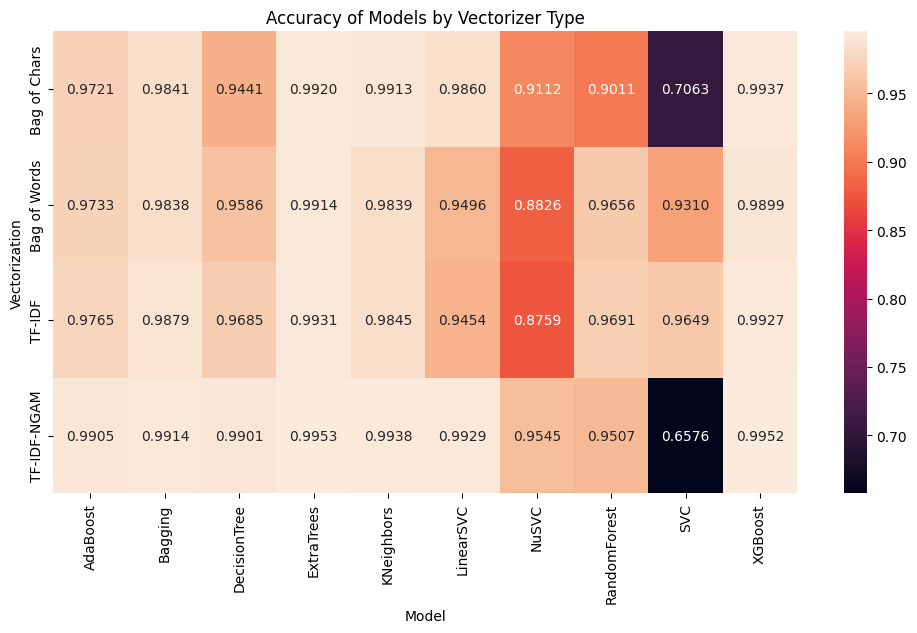

In [267]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title("Accuracy of Models by Vectorizer Type")
plt.ylabel("Vectorization")
plt.xlabel("Model")
plt.show()

* TF-IDF-NGAM векторизация для всех моделей, кроме SVC показывает самый лучший результат.
* Для SVC она показывает наоборот самый худший результат. При этом для этой модели самый лучший результат показывает TF-IDF векторизация, которая для всех остальных моделей наоборот дает наихудший результат. Но как говорилось выше - скорее всего дело в настройке гиперпараметров.
* Модель RandomForest, которую обычно советуют брать для решения большинства задач, для нашей задачи особо не подошла - она является одной из худших среди всех моделей для всех типов векторизаций. Но опять же - скорее всего дело в настройке гиперпараметров.

Попробуем подобрать гиперпараметры для SVC с помощью GridSearchCV

In [268]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
svc_model = SVC(random_state=666)
grid_search = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=2,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(tf_idf_ngram_feature_selected, y_train)
print("Best params:", grid_search.best_params_)
print("Dest score:", grid_search.best_score_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
Best params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Dest score: 0.9954805349717373


Судя по результатам, мы смогли значительно повысить точность. Проверим это

In [269]:
vectorized_features = {
    "TF-IDF": tf_idf_feature_selected,
    "TF-IDF-NGAM": tf_idf_ngram_feature_selected,
    "Bag of Words": bag_of_words_feature_selected,
    "Bag of Chars": bag_of_chars_feature_selected
}
svc_results = []
for vectorization_type, x_features in vectorized_features.items():
    default_params = {'gamma': 2, 'C': 1, 'kernel': 'rbf'}
    model = SVC(random_state=42, C=10, gamma="scale", kernel='rbf')
    scores, best_model = cross_validation(model, x_features, y_train)
    #scores, best_model = cross_validation(model, x_features, y_train)
    #scores, best_model = cross_validation(model, x_features, y_train)
    mean_score = sum(scores) / len(scores)
    svc_results.append({"Vectorization": vectorization_type, "Model": Models.SVC, "Accuracy": mean_score})
svc_results_df = pd.DataFrame(svc_results)
svc_pivot_table = svc_results_df.pivot(index="Vectorization", columns="Model", values="Accuracy")
print(svc_pivot_table.round(4))

Model             SVC
Vectorization        
Bag of Chars   0.9924
Bag of Words   0.9674
TF-IDF         0.9756
TF-IDF-NGAM    0.9951
